In [92]:
import os
from shutil import rmtree
import math
import random
from termcolor import colored
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from prepare_data import get_data
from sklearn.model_selection import train_test_split
from constant import CANDLES_HISTORY
from add_indicators import get_column_indicators

In [99]:
if os.path.exists("resources/model"):
    rmtree("resources/model")
if os.path.exists("resources/parameters"):
    rmtree("resources/parameters")
if os.path.exists("logs/fit"):
    rmtree("logs/fit")

In [100]:
def get_dataset(train_data):
    x_train = []
    for i in range(CANDLES_HISTORY, len(train_data)):
        x_train.append(train_data[i-CANDLES_HISTORY:i, :-1])
    return np.array(x_train)

In [101]:
def create_model(shape_examples, shape_features):
    print(colored('Generating LSTM model.', 'yellow'))
    print(colored(f'Shape {shape_examples}x{shape_features}', 'cyan'))

    model = Sequential()
    model.add(LSTM(
        units=10,
        return_sequences=True,
        input_shape=(shape_examples, shape_features)
    ))
    model.add(LSTM(units=10, return_sequences=True))
    model.add(LSTM(units=10))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [102]:
try:
    df = pd.read_csv("resources/test.csv")
except FileNotFoundError:
    print(colored('Creating missing file.', 'red'))
    get_data()
    df = pd.read_csv("resources/test.csv")

df = df.iloc[48680:, :]
df.reset_index(inplace=True, drop=True)
df = df[[] + get_column_indicators(df) + ["prediction"]]
df[(CANDLES_HISTORY - 5):(CANDLES_HISTORY + 5)]

,STOCHd_20_3_3,SMA_20,STOCHk_20_3_3,STDEV_20,SMA_5,RSI_20,prediction
15,96.272496,12033.6015,96.882784,52.601900,12086.516,66.045518,12083.31
16,96.714588,12041.0530,96.709672,48.159775,12086.546,64.318847,12061.81
17,94.508285,12045.7830,89.932399,45.072177,12081.450,58.308480,12062.10
18,89.941831,12050.5010,83.183422,41.249476,12077.062,58.363722,12053.82
19,82.791510,12054.9190,75.258709,36.068309,12070.018,56.128528,12055.94
20,76.749129,12058.5590,71.805256,31.872576,12063.396,56.576733,12057.77
21,71.718361,12061.8080,68.091118,27.876893,12058.288,56.976121,12054.40
22,68.063927,12065.0570,64.295406,22.206018,12056.806,55.978085,12036.01
23,61.573726,12066.3195,52.334654,19.510758,12051.588,50.860529,12038.90
24,51.220866,12066.9015,37.032538,18.427859,12048.604,51.592592,12038.18


In [103]:
try:
    X = np.load('resources/parameters/X.npy')
    Y = np.load('resources/parameters/Y.npy')
    scaler = joblib.load("resources/parameters/scaler.save")
    print(colored('Loaded storaged data.', 'green'))
except FileNotFoundError:
    print(colored('Setting up parameters.', 'yellow'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.values)

    if not os.path.exists("resources/parameters"):
        os.makedirs("resources/parameters")

    joblib.dump(scaler, "resources/parameters/scaler.save")
    X = get_dataset(scaled_data)
    Y = np.array(scaled_data[CANDLES_HISTORY:len(scaled_data), -1])
    np.save("resources/parameters/X.npy", X)
    np.save("resources/parameters/Y.npy", Y)
    print(colored('Parameters saved succesfully.', 'green'))


Setting up parameters.
Parameters saved succesfully.


In [104]:
RANDOM_VALUE = random.randint(0, len(Y))
check_split_df = pd.DataFrame(X[CANDLES_HISTORY + RANDOM_VALUE])
check_split_df["prediction"] = Y[RANDOM_VALUE:CANDLES_HISTORY + RANDOM_VALUE]
check_split_df = scaler.inverse_transform(check_split_df.values)
check_split_df = pd.DataFrame(check_split_df)
print(RANDOM_VALUE)
print(check_split_df.loc[0].values)
print(df.loc[CANDLES_HISTORY + RANDOM_VALUE].values)

all(check_split_df.loc[0].values.round() == df.loc[CANDLES_HISTORY + RANDOM_VALUE].values.round())



15145
[6.62707342e+01 1.63775245e+04 5.53550789e+01 1.48754143e+01
 1.63662880e+04 5.67210630e+01 1.63920600e+04]
[6.62707342e+01 1.63775245e+04 5.53550789e+01 1.48754143e+01
 1.63662880e+04 5.67210630e+01 1.63920600e+04]


True

In [105]:
PERCENTAGE_DATA = 0.3

print(colored(f'X shape: {X.shape}', 'yellow'))
print(colored(f'Y shape: {Y.shape}', 'yellow'))

training_data_len = math.ceil(len(Y) * .80)
x_train = X[:training_data_len]
y_train = Y[:training_data_len]

zipped = list(zip(x_train, y_train))
random.shuffle(zipped)
zipped_len_train = math.ceil(len(zipped) - len(zipped) * PERCENTAGE_DATA)
zipped = zipped[:zipped_len_train]
x_train, y_train = zip(*zipped)

x_train = np.array(x_train)
y_train = np.array(y_train)

print(colored(f'X_train shape: {x_train.shape}', 'blue'))
print(colored(f'Y_train shape: {y_train.shape}', 'blue'))

divition = training_data_len  # + (len(Y[training_data_len:]) / 5)
shrink = math.ceil(divition)
x_test = X[shrink:-1]
y_test = Y[shrink:-1]

zipped = list(zip(x_test, y_test))
random.shuffle(zipped)
zipped_len_test = math.ceil(len(zipped) - len(zipped) * PERCENTAGE_DATA)
zipped = zipped[:zipped_len_test]
x_test, y_test = zip(*zipped)

x_test = np.array(x_test)
y_test = np.array(y_test)

print(colored(f'X_test shape: {x_test.shape}', 'cyan'))
print(colored(f'Y_test shape: {y_test.shape}', 'cyan'))
print(colored(f'Shrink: {shrink}', 'red'))


X shape: (22007, 20, 6)
Y shape: (22007,)
X_train shape: (12325, 20, 6)
Y_train shape: (12325,)
X_test shape: (3080, 20, 6)
Y_test shape: (3080,)
Shrink: 17606


In [106]:

def get_len(samples):
    return math.ceil(len(samples) * PERCENTAGE_DATA)


def compute_total():
    return (
        (y_test.shape[0] + get_len(Y[training_data_len:]))
        +
        (
            shrink - (
                y_train.shape[0] +
                get_len(Y[:training_data_len])
            )
        )
        +
        (y_train.shape[0] + get_len(Y[:training_data_len]))
    )


print('test + train:', colored(
    compute_total(),
    'green' if (compute_total()) else 'red'
))

test + train: 22007


In [107]:
try:
    model = load_model('resources/model/my_model_sequential.h5')
    print(colored('Model loaded successfully', 'green'))
except IOError:
    if not os.path.exists("resources/model"):
        os.makedirs("resources/model")
    print(colored('Training...', 'yellow'))
    model = create_model(X.shape[1], X.shape[-1])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    checkpoint = ModelCheckpoint(
        'resources/model/best_model_checkpoint.h5',
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True
    )
    log_dir = "logs/fit"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(
        x_train, y_train, batch_size=128, epochs=1000,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint, tensorboard_callback, es]
    )

    model.save('resources/model/my_model_sequential.h5')
    hist_df = pd.DataFrame(history.history)
    with open('resources/model/history_sequential.csv', mode='w') as f:
        hist_df.to_csv(f)


Training...
Generating LSTM model.
Shape 20x6
Epoch 1/1000
97/97 [==============================] - ETA: 0s - loss: 0.0747
Epoch 1: val_loss improved from inf to 0.00281, saving model to resources/model/best_model_checkpoint.h5
97/97 [==============================] - 18s 75ms/step - loss: 0.0747 - val_loss: 0.0028
Epoch 2/1000
97/97 [==============================] - ETA: 0s - loss: 0.0011
Epoch 2: val_loss improved from 0.00281 to 0.00079, saving model to resources/model/best_model_checkpoint.h5
97/97 [==============================] - 5s 49ms/step - loss: 0.0011 - val_loss: 7.8881e-04
Epoch 3/1000
96/97 [============================>.] - ETA: 0s - loss: 5.6029e-04
Epoch 3: val_loss improved from 0.00079 to 0.00059, saving model to resources/model/best_model_checkpoint.h5
97/97 [==============================] - 5s 48ms/step - loss: 5.5949e-04 - val_loss: 5.9011e-04
Epoch 4/1000
97/97 [==============================] - ETA: 0s - loss: 4.5299e-04
Epoch 4: val_loss improved from 0.0005

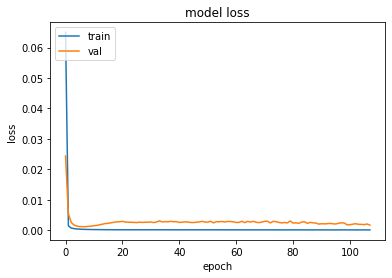

In [89]:
history = pd.read_csv("resources/model/history_sequential.csv")
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [90]:
train_acc = model.evaluate(x_train, y_train, verbose=0)
train_acc

7.392885163426399e-05

In [91]:
# index = 1
# sample = np.array([x_test[index]])

# y_sample = scaler.inverse_transform([[y_test[index]] * 7 + [y_test[index]]])
# print(y_sample[0][-1])
# prediction = model.predict(sample)[0][0]
# data = scaler.inverse_transform([[prediction] * 7 + [prediction]])
# print(data[0][-1])
# print("train: ", mean_squared_error(y_train, prediction))
